<a href="https://colab.research.google.com/github/yankikalfa/SAIS-ML-for-Finance/blob/main/Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 3: Decision Trees, Random Forests, and Boosted Trees

## Objectives
* Forecasting excess returns using:
  * Decision Trees
  * Random Forests
  * Boosted Trees
* Hyperparameter search over prespecified Validation Set

We will use the Goyal Welch dataset to forecast excess returns. We will compare the in sample and out sample fit of each of the methods. We will show different feature importance graphs, and try to understand the output.

## Libraries and Data

In [ ]:
! pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor,export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from IPython.display import Image

import warnings
warnings.filterwarnings("ignore")
plt.style.use('bmh')
plt.rcParams["figure.figsize"] = (16,8)

In [ ]:
df = pd.read_csv('GWdata.csv')
df['yyyymm'] = pd.to_datetime(df['yyyymm'],format='%Y%m', errors='coerce')
df.set_index('yyyymm',inplace=True)
df['er'] = df['CRSP_SPvw'] - df['Rfree']
df.drop(['CRSP_SPvw','Rfree','Index'],axis=1,inplace=True)
Y = df.loc['1927-01-01':,'er'].reset_index(drop=True)
X = df.loc[:'2021-11-01', df.columns!='er'].reset_index(drop=True)

In [ ]:
df.head()

,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,infl,ltr,corpr,svar,er
yyyymm,,,,,,,,,,,,,
1926-12-01,0.6900,1.240,0.441476,0.0307,0.0468,0.0568,0.0354,0.050876,0.000000,0.0078,0.0056,0.000465,0.023247
1927-01-01,0.6967,1.229,0.443706,0.0323,0.0466,0.0561,0.0351,0.050824,-0.011299,0.0075,0.0056,0.000470,-0.005410
1927-02-01,0.7033,1.218,0.428501,0.0329,0.0467,0.0559,0.0347,0.051668,-0.005714,0.0088,0.0069,0.000287,0.042922
1927-03-01,0.7100,1.208,0.469765,0.0320,0.0462,0.0554,0.0331,0.046357,-0.005747,0.0253,0.0083,0.000924,0.004324
1927-04-01,0.7167,1.197,0.456754,0.0339,0.0458,0.0548,0.0333,0.050514,0.000000,-0.0005,0.0055,0.000603,0.010521


### Training, Validation, Test

In [ ]:
X_train = X.iloc[:-240,]
X_train

,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,infl,ltr,corpr,svar
0,0.6900,1.2400,0.441476,0.0307,0.0468,0.0568,0.0354,0.050876,0.000000,0.0078,0.0056,0.000465
1,0.6967,1.2290,0.443706,0.0323,0.0466,0.0561,0.0351,0.050824,-0.011299,0.0075,0.0056,0.000470
2,0.7033,1.2180,0.428501,0.0329,0.0467,0.0559,0.0347,0.051668,-0.005714,0.0088,0.0069,0.000287
3,0.7100,1.2080,0.469765,0.0320,0.0462,0.0554,0.0331,0.046357,-0.005747,0.0253,0.0083,0.000924
4,0.7167,1.1970,0.456754,0.0339,0.0458,0.0548,0.0333,0.050514,0.000000,-0.0005,0.0055,0.000603
...,...,...,...,...,...,...,...,...,...,...,...,...
895,15.7027,33.9633,0.124967,0.0351,0.0713,0.0797,0.0561,0.007914,-0.002809,0.0376,0.0361,0.002900
896,15.7193,31.1367,0.132164,0.0336,0.0702,0.0785,0.0546,0.009918,0.000000,0.0206,0.0156,0.002222
897,15.7360,28.3100,0.148629,0.0264,0.0717,0.0803,0.0542,0.008653,0.004507,0.0081,-0.0152,0.007168
898,15.7373,27.1033,0.144901,0.0216,0.0703,0.0791,0.0506,0.010749,-0.003365,0.0464,0.0437,0.003250


In [ ]:
X_val = X.iloc[900:-120,]
X_val

,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,infl,ltr,corpr,svar
900,15.7400,24.6900,0.131218,0.0169,0.0677,0.0805,0.0575,0.013465,-0.003946,-0.0183,-0.0090,0.001798
901,15.7367,24.6933,0.132561,0.0165,0.0655,0.0787,0.0569,0.011191,0.002264,0.0138,0.0175,0.002184
902,15.7333,24.6967,0.130119,0.0172,0.0651,0.0789,0.0563,0.012499,0.003953,0.0115,0.0130,0.002568
903,15.7300,24.7000,0.236833,0.0179,0.0681,0.0811,0.0604,0.013759,0.005624,-0.0436,-0.0295,0.002015
904,15.8330,25.3800,0.247732,0.0171,0.0676,0.0803,0.0575,0.015107,0.005593,0.0410,0.0253,0.002320
...,...,...,...,...,...,...,...,...,...,...,...,...
1015,24.6210,84.9067,0.359419,0.0004,0.0493,0.0576,0.0378,0.012371,0.000886,0.0422,0.0473,0.001831
1016,24.9010,85.9433,0.375813,0.0002,0.0437,0.0536,0.0315,0.012727,0.002758,0.0862,0.0240,0.019222
1017,25.1810,86.9800,0.399923,0.0001,0.0409,0.0527,0.0265,0.013049,0.001518,0.0704,0.0575,0.006916
1018,25.5957,86.9700,0.365078,0.0002,0.0398,0.0537,0.0291,0.007893,-0.002063,-0.0306,0.0094,0.007401


In [ ]:
X_test = X.iloc[-120:,]
X_test

,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,infl,ltr,corpr,svar
1020,26.4250,86.9500,0.357233,0.0001,0.0393,0.0525,0.0255,-0.006497,-0.002467,0.0270,0.0512,0.002764
1021,26.7343,87.4800,0.345487,0.0003,0.0385,0.0523,0.0249,-0.013062,0.004400,0.0002,0.0194,0.000648
1022,27.0437,88.0100,0.336974,0.0009,0.0385,0.0514,0.0272,-0.014466,0.004403,-0.0196,0.0057,0.000624
1023,27.3530,88.5400,0.346182,0.0008,0.0399,0.0523,0.0297,-0.013775,0.007595,-0.0302,-0.0303,0.001155
1024,27.6753,88.3333,0.346140,0.0008,0.0396,0.0519,0.0268,-0.012414,0.003021,0.0409,0.0251,0.001628
...,...,...,...,...,...,...,...,...,...,...,...,...
1135,58.3282,164.2967,0.187005,0.0005,0.0257,0.0324,0.0132,0.016079,0.004811,0.0305,0.0239,0.001124
1136,58.7913,169.8333,0.184756,0.0005,0.0255,0.0324,0.0128,0.014846,0.002066,-0.0035,-0.0045,0.000602
1137,59.2545,175.3700,0.193036,0.0004,0.0253,0.0323,0.0137,0.015598,0.002716,-0.0250,-0.0194,0.001393
1138,59.6354,182.8600,0.182389,0.0005,0.0268,0.0335,0.0158,0.013368,0.008308,0.0051,0.0159,0.001151


In [ ]:
X_train_full = X.iloc[:-120,]
X_train_full


,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,infl,ltr,corpr,svar
0,0.6900,1.2400,0.441476,0.0307,0.0468,0.0568,0.0354,0.050876,0.000000,0.0078,0.0056,0.000465
1,0.6967,1.2290,0.443706,0.0323,0.0466,0.0561,0.0351,0.050824,-0.011299,0.0075,0.0056,0.000470
2,0.7033,1.2180,0.428501,0.0329,0.0467,0.0559,0.0347,0.051668,-0.005714,0.0088,0.0069,0.000287
3,0.7100,1.2080,0.469765,0.0320,0.0462,0.0554,0.0331,0.046357,-0.005747,0.0253,0.0083,0.000924
4,0.7167,1.1970,0.456754,0.0339,0.0458,0.0548,0.0333,0.050514,0.000000,-0.0005,0.0055,0.000603
...,...,...,...,...,...,...,...,...,...,...,...,...
1015,24.6210,84.9067,0.359419,0.0004,0.0493,0.0576,0.0378,0.012371,0.000886,0.0422,0.0473,0.001831
1016,24.9010,85.9433,0.375813,0.0002,0.0437,0.0536,0.0315,0.012727,0.002758,0.0862,0.0240,0.019222
1017,25.1810,86.9800,0.399923,0.0001,0.0409,0.0527,0.0265,0.013049,0.001518,0.0704,0.0575,0.006916
1018,25.5957,86.9700,0.365078,0.0002,0.0398,0.0537,0.0291,0.007893,-0.002063,-0.0306,0.0094,0.007401


In [ ]:
y_train = Y.loc[:900-1]
y_train

0     -0.005410
1      0.042922
2      0.004324
3      0.010521
4      0.059353
         ...   
895   -0.066535
896   -0.083161
897    0.017340
898    0.077087
899    0.007551
Name: er, Length: 900, dtype: float64

In [ ]:
y_val=Y.loc[900:1019]
y_val

900    -0.015724
901    -0.020781
902     0.036272
903    -0.062501
904    -0.009200
          ...   
1015   -0.054423
1016   -0.070238
1017    0.109014
1018   -0.002727
1019    0.009427
Name: er, Length: 120, dtype: float64

In [ ]:
y_test=Y.loc[1020:]
y_test

1020    0.045205
1021    0.043341
1022    0.032866
1023   -0.006034
1024   -0.059890
          ...   
1135    0.030600
1136   -0.046076
1137    0.070510
1138   -0.007356
1139    0.043485
Name: er, Length: 120, dtype: float64

We will use the validation set to tune the hyperparameters, and forecast the last 10 years of data. This is not a 120 step ahead forecast, it is 120, 1 step ahead forecast without changing the hyperparameter values.

In [ ]:
y_train_full= Y.loc[:1019]
y_train_full

0      -0.005410
1       0.042922
2       0.004324
3       0.010521
4       0.059353
          ...   
1015   -0.054423
1016   -0.070238
1017    0.109014
1018   -0.002727
1019    0.009427
Name: er, Length: 1020, dtype: float64

## Decision Trees

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

### Fitting a tree with default parameters

In [ ]:
tree = DecisionTreeRegressor()
tree_fit=tree.fit(X_train_full,y_train_full)
tree_predict = pd.Series(tree_fit.predict(X_test)).reset_index(drop=True).rename('f_tree')

In [ ]:
actual = pd.Series(y_test).reset_index(drop=True).rename('Actual')

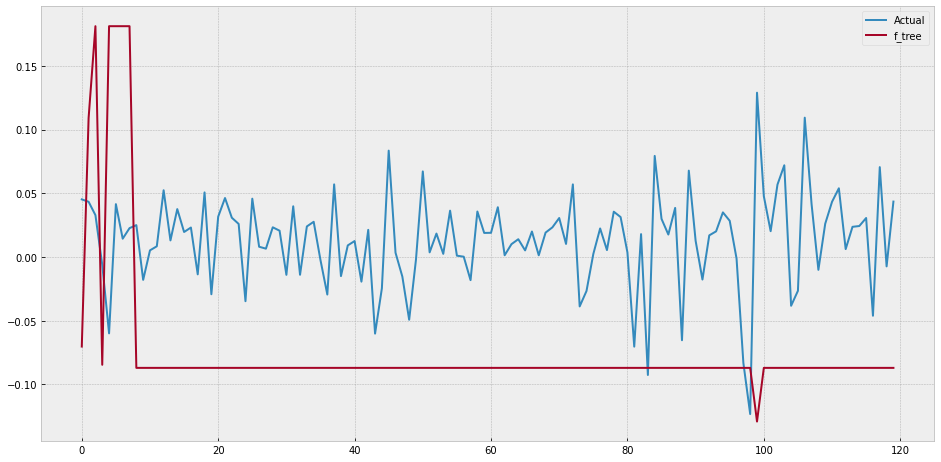

In [ ]:
forecasts=pd.concat([actual,tree_predict],axis=1)
forecasts.plot()

The forecasts look pretty bad. Now let's tune the hyperparameters using a for loop.

Hyperparameter tuning is a very important part of machine learning. We will use the validation set to tune the hyperparameters.

### Manual Hyperparameter Search

In [ ]:
depth=[]
splits=[]
leaves=[]
alpha=[]
mse=[]
for d in [5,10,20,30]:
  for s in [5,10,50,100,200]:
    for leaf in [1,5,10,100,200]:
      for a in [0,0.0001,0.001,0.01,0.1,1]:
        tree_tune = DecisionTreeRegressor(criterion='squared_error',
                                          max_depth=d,
                                          min_samples_split=s,
                                          min_samples_leaf=leaf,
                                          ccp_alpha=a)
        tree_fit=tree_tune.fit(X_train,y_train)
        tree_val = tree_fit.predict(X_val)
        depth.append(d)
        splits.append(s)
        leaves.append(leaf)
        alpha.append(a)
        mse.append(mean_squared_error(y_val,tree_val))



In [ ]:
validation_results = pd.concat([pd.Series(depth).rename('d'),
                                pd.Series(splits).rename('s'),
                                pd.Series(leaves).rename('l'),
                                pd.Series(alpha).rename('a'),
                                pd.Series(mse).rename('mse')],axis=1)

In [ ]:
validation_results.sort_values(by='mse')

,d,s,l,a,mse
198,10,10,100,0.0,0.002036
528,30,50,100,0.0,0.002036
558,30,100,100,0.0,0.002036
288,10,200,100,0.0,0.002036
168,10,5,100,0.0,0.002036
...,...,...,...,...,...
342,20,10,10,0.0,0.004291
450,30,5,1,0.0,0.006234
330,20,10,1,0.0,0.006680
480,30,10,1,0.0,0.006913


In [ ]:
validation_results.loc[validation_results['mse']==min(validation_results['mse'])]

,d,s,l,a,mse
168,10,5,100,0.0,0.002036
198,10,10,100,0.0,0.002036
228,10,50,100,0.0,0.002036
258,10,100,100,0.0,0.002036
288,10,200,100,0.0,0.002036
318,20,5,100,0.0,0.002036
348,20,10,100,0.0,0.002036
378,20,50,100,0.0,0.002036
408,20,100,100,0.0,0.002036
438,20,200,100,0.0,0.002036


In [ ]:
tree_tune = DecisionTreeRegressor(criterion='squared_error',
                                          max_depth=30,
                                          min_samples_split=200,
                                          min_samples_leaf=100,
                                          ccp_alpha=0)
tree_fit=tree_tune.fit(X_train_full,y_train_full)
tree_predict = pd.Series(tree_fit.predict(X_test)).reset_index(drop=True).rename('f_tree_tuned')



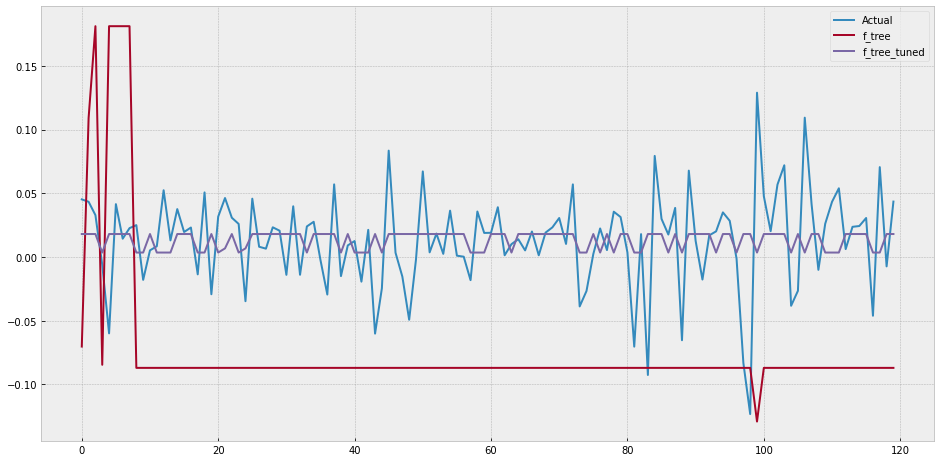

In [ ]:
forecasts=pd.concat([forecasts,tree_predict],axis=1)
forecasts.plot()

The "Tuned" tree has a much better fit

## Random Forests

### Random Forest with default parameters

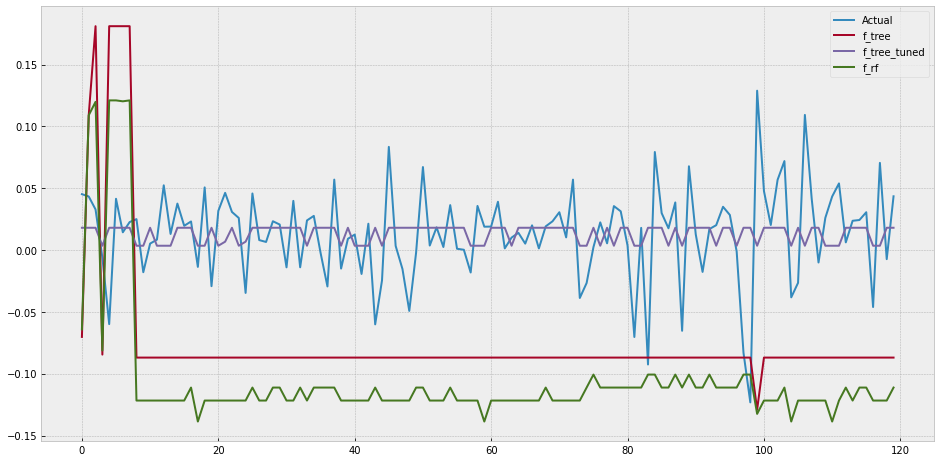

In [ ]:
rf = RandomForestRegressor(bootstrap=False)
rf_fit=rf.fit(X_train_full,y_train_full)
rf_predict = pd.Series(rf_fit.predict(X_test)).reset_index(drop=True).rename('f_rf')
forecasts=pd.concat([forecasts,rf_predict],axis=1)
forecasts.plot()

### Manual Hyperparameter Search for Random Forest

In [ ]:
n_tree=[]
depth=[]
splits=[]
leaves=[]
n_feature=[]
mse=[]
for n in [100,300]:
  for d in [5,10,20]:
    for s in [5,10,100]:
      for leaf in [1,10,100]:
        for a in ['sqrt',0.3]:
          rf_tune = RandomForestRegressor(n_jobs=-1, bootstrap=False,criterion='squared_error',
                                            n_estimators=n,
                                            max_depth=d,
                                            min_samples_split=s,
                                            min_samples_leaf=leaf,
                                            max_features=a)
          rf_fit=rf_tune.fit(X_train,y_train)
          rf_val = rf_fit.predict(X_val)
          n_tree.append(n)
          depth.append(d)
          splits.append(s)
          leaves.append(leaf)
          n_feature.append(a)
          mse.append(mean_squared_error(y_val,rf_val))

In [ ]:
validation_results = pd.concat([pd.Series(n_tree).rename('n'),
                                pd.Series(depth).rename('d'),
                                pd.Series(splits).rename('s'),
                                pd.Series(leaves).rename('l'),
                                pd.Series(n_feature).rename('a'),
                                pd.Series(mse).rename('mse')],axis=1)

In [ ]:
validation_results.sort_values(by='mse')

,n,d,s,l,a,mse
41,100,20,5,100,0.3,0.002070
22,100,10,5,100,sqrt,0.002073
77,300,10,5,100,0.3,0.002076
16,100,5,100,100,sqrt,0.002077
89,300,10,100,100,0.3,0.002078
...,...,...,...,...,...,...
54,300,5,5,1,sqrt,0.004964
6,100,5,10,1,sqrt,0.004994
97,300,20,10,1,0.3,0.005090
42,100,20,10,1,sqrt,0.005584


In [ ]:
validation_results.loc[validation_results['mse']==min(validation_results['mse'])]

,n,d,s,l,a,mse
41,100,20,5,100,0.3,0.00207


In [ ]:
rf_tune = RandomForestRegressor(n_jobs=-1, bootstrap=False,criterion='squared_error',
                                            n_estimators=100,
                                            max_depth=10,
                                            min_samples_split=100,
                                            min_samples_leaf=100,
                                            max_features='sqrt')
rf_fit=rf_tune.fit(X_train_full,y_train_full)
rf_predict = pd.Series(rf_fit.predict(X_test)).reset_index(drop=True).rename('f_rf_tuned')

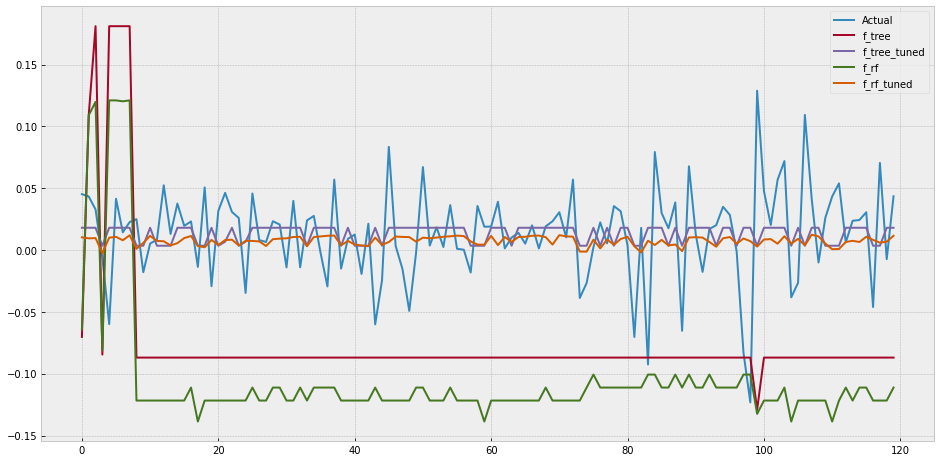

In [ ]:
forecasts=pd.concat([forecasts,rf_predict],axis=1)
forecasts.plot()

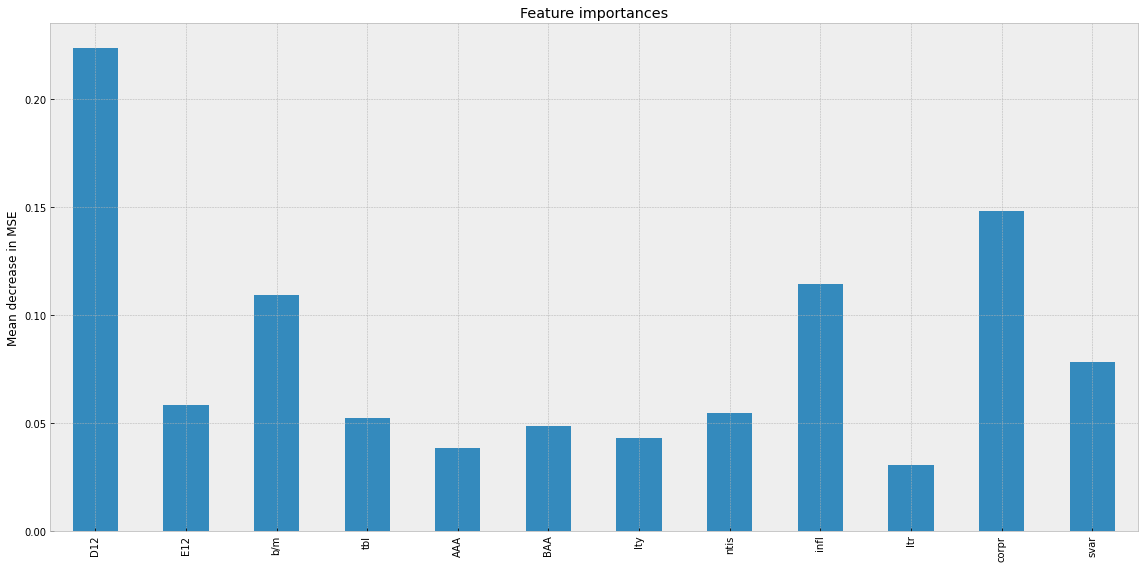

In [ ]:
import pandas as pd
importances= rf_fit.feature_importances_
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in MSE")
fig.tight_layout()

## Boosted Trees

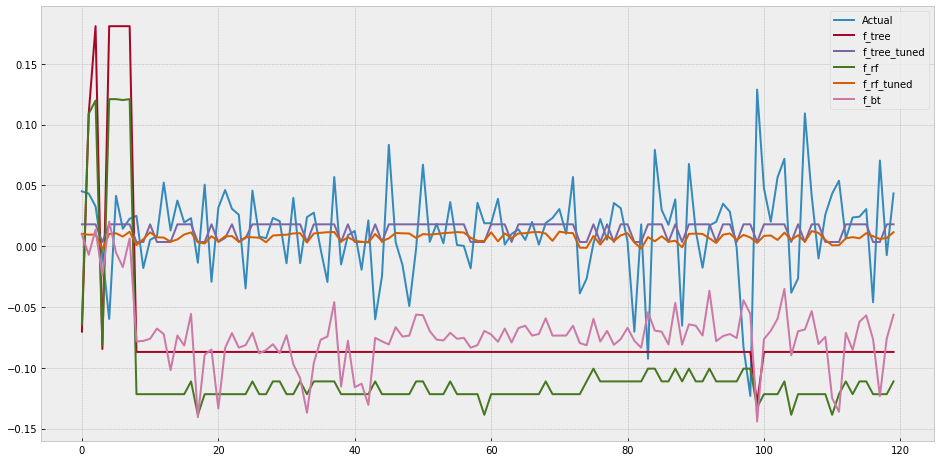

In [ ]:
bt = GradientBoostingRegressor()
bt_fit=bt.fit(X_train_full,y_train_full)
bt_predict = pd.Series(bt_fit.predict(X_test)).reset_index(drop=True).rename('f_bt')
forecasts=pd.concat([forecasts,bt_predict],axis=1)
forecasts.plot()

### Manual Search

In [ ]:
n_tree=[]
depth=[]
splits=[]
leaves=[]
n_feature=[]
learn=[]
mse=[]
for lrate in [0.0001,0.001,0.01,0.1,1]:
  for n in [300,500]:
    for d in [3,5]:
      for s in [5,10,100]:
        for leaf in [1,10,100]:
          for a in ['sqrt',0.3]:
            bt_tune = GradientBoostingRegressor(loss='squared_error', criterion='squared_error',
                                              n_estimators=n,
                                              max_depth=d,
                                              min_samples_split=s,
                                              min_samples_leaf=leaf,
                                              max_features=a,
                                            learning_rate=lrate)
            bt_fit=bt_tune.fit(X_train,y_train)
            bt_val = bt_fit.predict(X_val)
            n_tree.append(n)
            depth.append(d)
            splits.append(s)
            leaves.append(leaf)
            n_feature.append(a)
            learn.append(lrate)
            mse.append(mean_squared_error(y_val,bt_val))

In [ ]:
validation_results = pd.concat([pd.Series(n_tree).rename('n'),
                                pd.Series(depth).rename('d'),
                                pd.Series(splits).rename('s'),
                                pd.Series(leaves).rename('l'),
                                pd.Series(n_feature).rename('a'),
                                pd.Series(learn).rename('learn'),
                                pd.Series(mse).rename('mse')],axis=1)


In [ ]:
validation_results.loc[validation_results['mse']==min(validation_results['mse'])]

In [ ]:
bt_tune = GradientBoostingRegressor(loss='squared_error', criterion='squared_error',
                                              n_estimators=500,
                                              max_depth=5,
                                              min_samples_split=100,
                                              min_samples_leaf=100,
                                              max_features='sqrt',
                                            learning_rate=0.001)
bt_fit=bt_tune.fit(X_train_full,y_train_full)
bt_predict = pd.Series(bt_fit.predict(X_test)).reset_index(drop=True).rename('f_bt_tuned')

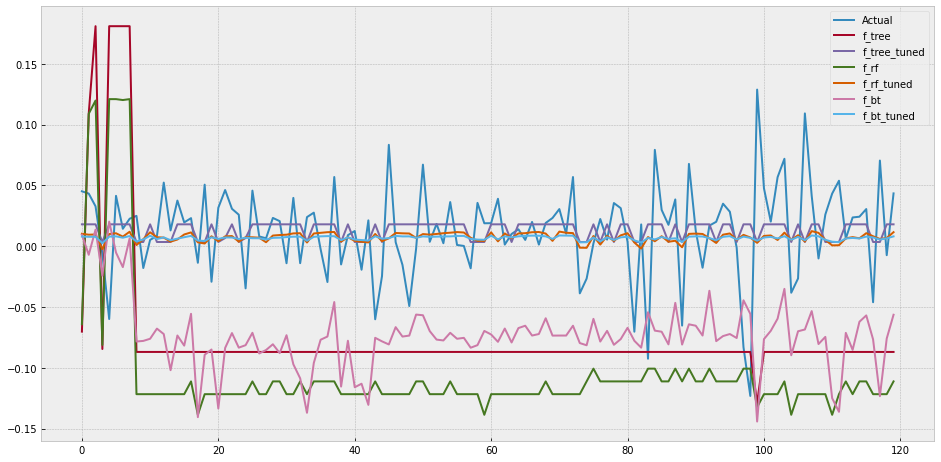

In [ ]:
forecasts=pd.concat([forecasts,bt_predict],axis=1)
forecasts.plot()

In [ ]:
forecasts

,Actual,f_tree,f_tree_tuned,f_rf,f_rf_tuned,f_bt,f_bt_tuned
0,0.045205,-0.070238,0.018035,-0.064153,0.010278,0.009496,0.007988
1,0.043341,0.109014,0.018035,0.109014,0.009495,-0.007044,0.007769
2,0.032866,0.181067,0.018035,0.119883,0.009672,0.013711,0.007823
3,-0.006034,-0.084542,0.003497,-0.081203,-0.002396,-0.024179,0.002506
4,-0.059890,0.181067,0.018035,0.121048,0.010025,0.020277,0.007933
...,...,...,...,...,...,...,...
115,0.030600,-0.086967,0.018035,-0.111211,0.010748,-0.056924,0.007946
116,-0.046076,-0.086967,0.003497,-0.121717,0.008208,-0.076645,0.007214
117,0.070510,-0.086967,0.003497,-0.121717,0.005978,-0.123360,0.005532
118,-0.007356,-0.086967,0.018035,-0.121717,0.006788,-0.075922,0.006517
